In [1]:
# import pandas as pd
# import numpy as np
# def read_Airbnb_data(datafile):
#     import pandas as pd
#     import numpy as np
#     #Add the fix_zip function
#     def fix_zip(input_zip):
#         try:
#             input_zip = int(float(input_zip))
#         except:
#             try:
#                 input_zip = int(input_zip.split('-')[0])
#             except:
#                 return np.NaN
#         if input_zip < 10000 or input_zip > 19999:
#             return np.NaN
#         return str(input_zip)
#     #Add the fix_price function
#     def fix_price(input_price):
#         try:
#             input_price = float(input_price)
#         except:
#             try:
#                 input_price = float(input_price[1:])
#             except:
#                 return np.NaN
#         return input_price
    
#     #Read datafile
#     df = pd.read_csv(datafile)
#     df = df.loc[:,['price','id','name','room_type','accommodates','zipcode','bedrooms','beds','latitude','longitude',
#                    'cleaning_fee','bathrooms','review_scores_rating','neighbourhood','number_of_reviews',
#                    'security_deposit','host_listings_count','description','reviews_per_month']]
    
#     #Fix zipcode
#     df['zipcode'] = df['zipcode'].apply(fix_zip)
#     df['price'] = df['price'].apply(fix_price)
#     df['cleaning_fee'] = df['cleaning_fee'].apply(fix_price)
#     df['security_deposit'] = df['security_deposit'].apply(fix_price)
    
    
#     df.dropna(inplace=True)
#     df = df[df['number_of_reviews']>0]
#     df = df[df['price']>0]
    
#     return df
# df = read_Airbnb_data('listings_detailed.csv')
# df.to_csv('listings_detailed_modified.csv')

## Part1: Input the dataset
<li> Listing_detailed_modified.csv is the dataset has been cleaned for regression part.-->df
    <li>reviews_detail.csv is the dataset for reviews. -->df_description

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('listings_detailed_modified.csv')
df = df.loc[:,['price','id','review_scores_rating','number_of_reviews','description','reviews_per_month']]

In [3]:
df_description = pd.read_csv('reviews_detail.csv')
df_description.dropna(inplace = True)

## Part2: Use Wordcloud to find the key word for a good description
<li> The data we choose is the Aribnb House which have a rating higher than 90, which helps us to make sure that it is a good house.
    <li>We can not choose the overall number of reviews to decide which house is popular, since the begin date of the house is different. As a result, we choose the variable reviews per month. If the reviews_per_month of a house is bigger than 7, which means they are top 198 popular house, and we sort the dataframe by reviews_per_month and find the 198 houses with the lowest number of reviews_per_month. 
        <li> We use wordcloud to analysis the description of the houses and find the differences. 

In [4]:
df_review = df[df['review_scores_rating']>90]
df_review_lot = df_review[df_review['reviews_per_month']>=7]
df_review_less = df_review.sort_values(by=['reviews_per_month'],ascending=False).tail(198)
print(len(df_review_less),len(df_review_lot))

198 198


In [5]:
def visual_review_number(df,level):
    import random
    from random import randint
    review_index = []
    for i in df.index:
        review_index.append(i)
    text_des = ''
    for i in review_index:
        text_des += df.loc[i,'description']
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    %matplotlib inline
    if level == 'high':
        def random_color_func(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
                h  = randint(272,354)
                s = 88
                l = int(100.0 * float(randint(65, 77)) / 100.0)
                return "hsl({}, {}%, {}%)".format(h, s, l)
        wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=3000,height=3000,color_func = random_color_func).generate(text_des)
    else:
        wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=3000,height=3000).generate(text_des)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.title(f'Airbnb House with {level} number of reviews description ')
    plt.axis('off')
    plt.show()


From the pictures below, we can find that the keyword for popular house and unpopular house. 

popular house: home, guest, room, apartment, bedroom, space, kitchen

unpopular house: The size for a lot of words are the same, which means all the host write different and it do not have word guest and home.

#### We make the conclusion that the biggest difference between the description of popular and unpopular house is that the host of popular house emphasis on making the guest feel at home. And this kind of description is more emotional than just describing the house and neighborhood, which may attract guests more.

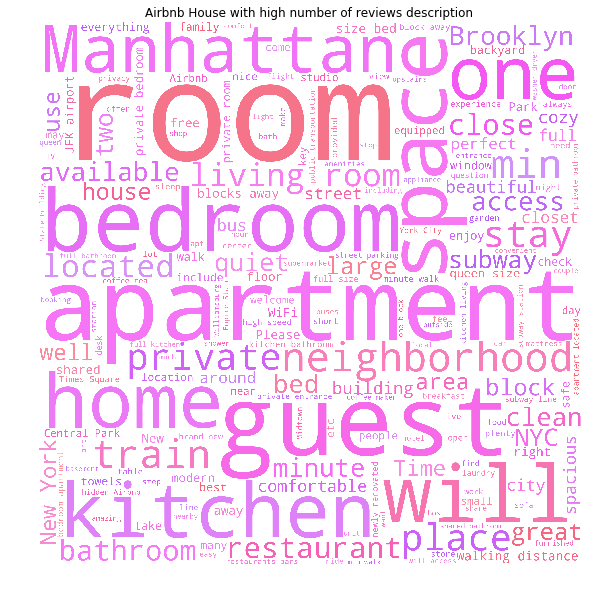

In [6]:
visual_review_number(df_review_lot,'high')

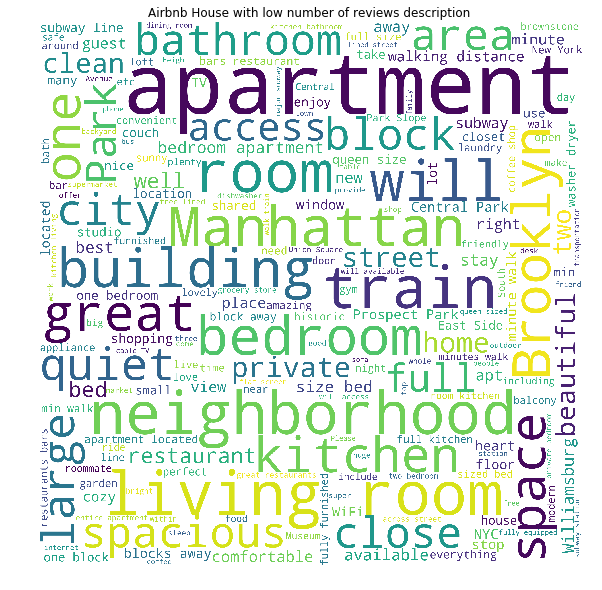

In [7]:
visual_review_number(df_review_less,'low')

## Part3: Emotional Analysis

<li> In this part we want to know what makes the guest give low rate for a house by analysing their emotion. 
   <li> For the dataset, we choose the house with number of reviews more than 100, which could give us more text to analysis, also, we find two group , first is the top 50 highest rating house, second one is the top 50 lowest rating house.
       <li> We use nrc to analysis the different emotion of the guest for every house and calculate the mean for two group and visualize the result.

In [8]:
nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
count=0
emotion_dict=dict()
with open(nrc,'r') as f:
    all_lines = list()
    for line in f:
        if count < 46:
            count+=1
            continue
        line = line.strip().split('\t')
        if int(line[2]) == 1:
            if emotion_dict.get(line[0]):
                emotion_dict[line[0]].append(line[1])
            else:
                emotion_dict[line[0]] = [line[1]]

In [9]:
def emotion_analyzer(text,emotion_dict=emotion_dict):
    #Set up the result dictionary
    emotions = {x for y in emotion_dict.values() for x in y}
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0

    #Analyze the text and normalize by total number of words
    total_words = len(text.split())
    for word in text.split():
        if emotion_dict.get(word):
            for emotion in emotion_dict.get(word):
                emotion_count[emotion] += 1/len(text.split())
    return emotion_count

In [10]:
df_reviews_more_than_100 = df[df['number_of_reviews']>100]
df_sort = df_reviews_more_than_100.sort_values(by=['review_scores_rating'],ascending=False)
df_good = df_sort.head(50)
df_bad = df_sort.tail(50)

In [11]:
def sentiment_analysis(df):
    id_ = []
    for i in df.index:
        id_.append(df.loc[i,'id'])
    dic_ = dict()
    for i in id_:
        n = df_description[df_description['listing_id']==i]
        dic_[i] = n
    text_dic = {}
    for i in dic_.keys():
        text_ = ''
        for j in dic_[i].index:
            text_ += dic_[i].loc[j,'comments']
        text_dic[i] = text_
#     print(" %1s\t%1s %1s   %1s %1s %1s %1s"%(
#             "fear","trust","joy","disgust","anticip",
#             "sadness","surprise"))
    result_emotion = pd.DataFrame(np.zeros(7)).transpose()
    for i in text_dic.keys():
        result = emotion_analyzer(text_dic[i])
        result_emotion.loc[i] = [result['fear'],result['trust'],
              result['joy'],result['disgust'],
              result['anticipation'],result['sadness'],result['surprise']]
    result_emotion.columns = ["fear","trust","joy","disgust","anticip","sadness","surprise"]
    return list(result_emotion.iloc[1:].mean())

In [12]:
good = sentiment_analysis(df_good)

In [13]:
bad = sentiment_analysis(df_bad)

We Visualize the seven variables 'fear', 'trust', 'joy', 'disgust', 'anticip', 'sadness', 'surprise', and we find that the biggest difference is the joy, the second is the trust. 

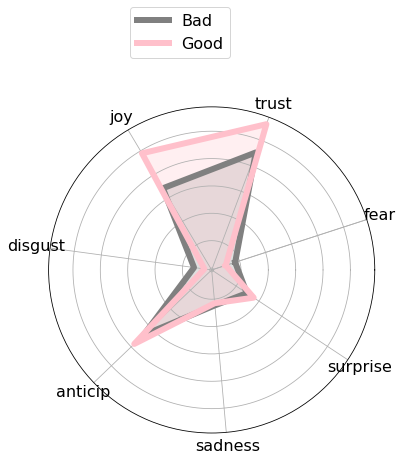

In [16]:
def Visualize_emotion():
    import matplotlib.pyplot as plt
    name1 = 'Bad'
    name2 = 'Good'
    cols = ['fear', 'trust', 'joy', 'disgust', 'anticip', 'sadness', 'surprise']
    angles = np.linspace(0.1 * np.pi, 2.1 * np.pi, len(cols), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, polar=True)
    stats = bad
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='grey', label='%s'%name1)
    ax.fill(angles, stats, c='grey', alpha=0.25)
    stats = good
    stats = np.concatenate((stats, [stats[0]]))
    ax.plot(angles, stats, '-', linewidth=6, c='pink', label='%s'%name2)
    ax.fill(angles, stats, c='pink', alpha=0.25)
    ax.legend(loc=[0.25, 1.15], fontsize=16)
    ax.set_yticklabels([])
    ax.set_thetagrids(angles * 180/np.pi, cols, fontsize=16)
    ax.grid(True)
Visualize_emotion()